<a href="https://colab.research.google.com/github/pietrodileo/Python_for_MD_thesis/blob/main/CNN_CrossValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 Import Libraries

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2

# !pip install tensorflow==2.8
# !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mimg
%matplotlib inline
from scipy import misc
import sklearn
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# DEEP LEARNING IMPORTS
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Activation, Dropout, Flatten, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import wave
import pylab
import sys
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
from keras.utils.vis_utils import plot_model
import itertools
import time
import shutil
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
!pip install pyyaml h5py  # Required to save models in HDF5 format

!pip install -U kaleido
#need to restart runtime after install kaleido
import kaleido
import plotly.express as px

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 1.2 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ⏰ Execution time

In [3]:
start_time = time.time()

# 🛫 Define Training Parameters

In [4]:
#@title Declare Constants
#@markdown ---
fileName = 'C18' #@param {type: "string"}
# K fold CrossValidation
k = 10 #@param {type: "number"}
num_cnn_layers = 4 #@param {type: "number"}
IMAGE_HEIGHT = 256 #@param {type: "number"}
IMAGE_WIDTH = 256 #@param {type: "number"}
BATCH_SIZE = 32 #@param {type: "slider", min: 1, max: 256}
EPOCHS = 100  #@param {type: "number"}
VAL_SPLIT = 0.75  #@param {type: "slider", min: 0, max: 1, step:0.05}
MODE = "grayscale"  #@param ['rgb', 'rgba', 'grayscale']
SaveFile = True #@param {type: "boolean"}
#@markdown ---

# 📑 Unzip Directory

In [5]:
TASK = str(EPOCHS) + 'EP_' + str(num_cnn_layers) + 'conv_' + 'Batch' + str(BATCH_SIZE) + '_adam_' + str(k) + 'foldCV_' + fileName  
TASK

'100EP_4conv_Batch32_adam_10foldCV_C18'

In [6]:
zipfile = fileName + '.zip'
directory = '/content/drive/MyDrive/TesiMagistrale/outputSpectrogram/CNN_TrainingIMGs/BW/'

zipPath = os.path.join(directory,zipfile)
outputDir = os.path.join(directory,'Risultati')
outputPath = os.path.join(outputDir,TASK)

if not os.path.exists(outputPath):
   # Create a new directory because it does not exist
   os.makedirs(outputPath)
   print("The output folder has been created!")

# Location of Zip File
drive_path = zipPath
local_path = '/content'

zipCopyPath = os.path.join(local_path,zipfile)
if not os.path.exists(zipCopyPath):
  # Copy the zip file and move it up one level (AKA out of the drive folder)
  !cp '{drive_path}' .
else:
  print('Files already transferred from Drive')

if not os.path.exists(fileName):
  # Navigate to the copied file and unzip it quietly
  os.chdir(local_path)
  !unzip -q '{zipfile}'
else:
  print('Files already unzipped')
# change directory to the new one
NewDir = os.path.join(local_path,fileName)

The output folder has been created!


# 🎨 Extract image path

In [7]:
valid_formats = [".png"]
pathlist = []
classnames = []
labVec = []
istanceVec = []
lablist = []
#dataclass = []
#dataAll = []
for folders in os.listdir(NewDir):
  # select a subfolder
  subfolder = os.path.join(NewDir,folders)
  # select all the records in the subfolder
  print('reading folder: '+ subfolder)
  subfolderList = []
  subfolderlabel = []
  pathVec = []
  for filename in os.listdir(subfolder):
    file_format = os.path.splitext(filename)[1] 
    if file_format.lower() in valid_formats:
      subfolderList.append(filename)
      currClass = os.path.split(subfolder)[1]
      labVec.append(currClass)
      istanceVec.append(filename)
      # extract file path
      pathVec.append(os.path.join(subfolder,filename))
      subfolderlabel.append(currClass)

  pathlist.append(pathVec)
  lablist.append(subfolderlabel)
  classnames.append(currClass)

reading folder: /content/C18/class_advanced_PD-OFF
reading folder: /content/C18/class_Early_PD
reading folder: /content/C18/class_DBS-onon
reading folder: /content/C18/class_HealthyControl


##Information about Data

In [8]:
pathColumns = pd.DataFrame(pathlist)
pathColumns = pathColumns.transpose()
pathColumns.columns = classnames
pathColumns.head(5)

,class_advanced_PD-OFF,class_Early_PD,class_DBS-onon,class_HealthyControl
0,/content/C18/class_advanced_PD-OFF/PD_OFF_Tesi...,/content/C18/class_Early_PD/PD_Early_TesiPDL_V...,/content/C18/class_DBS-onon/PD_DBS_ONON_TesiPD...,/content/C18/class_HealthyControl/HC_TesiPDL_V...
1,/content/C18/class_advanced_PD-OFF/PD_OFF_Tesi...,/content/C18/class_Early_PD/PD_Early_TesiPDL_V...,/content/C18/class_DBS-onon/PD_DBS_ONON_TesiPD...,/content/C18/class_HealthyControl/HC_TesiPDL_V...
2,/content/C18/class_advanced_PD-OFF/PD_OFF_Tesi...,/content/C18/class_Early_PD/PD_Early_TesiPDL_V...,/content/C18/class_DBS-onon/PD_DBS_ONON_TesiPD...,/content/C18/class_HealthyControl/HC_TesiPDL_V...
3,/content/C18/class_advanced_PD-OFF/PD_OFF_Tesi...,/content/C18/class_Early_PD/PD_Early_TesiPDL_V...,/content/C18/class_DBS-onon/PD_DBS_ONON_TesiPD...,/content/C18/class_HealthyControl/HC_TesiPDL_V...
4,/content/C18/class_advanced_PD-OFF/PD_OFF_Tesi...,/content/C18/class_Early_PD/PD_Early_TesiPDL_V...,/content/C18/class_DBS-onon/PD_DBS_ONON_TesiPD...,/content/C18/class_HealthyControl/HC_TesiPDL_V...


In [9]:
labColumns = pd.DataFrame(lablist)
labColumns = labColumns.transpose()
labColumns.columns = classnames
labColumns.head(2)

,class_advanced_PD-OFF,class_Early_PD,class_DBS-onon,class_HealthyControl
0,class_advanced_PD-OFF,class_Early_PD,class_DBS-onon,class_HealthyControl
1,class_advanced_PD-OFF,class_Early_PD,class_DBS-onon,class_HealthyControl


In [10]:
dictionary = {'Istance': istanceVec,'Class': labVec}
classVec = pd.DataFrame(data = dictionary)
classVec.head(4)

,Istance,Class
0,PD_OFF_TesiPDL_VowelE_0078_1_FineCut_Short_Tim...,class_advanced_PD-OFF
1,PD_OFF_TesiPDL_VowelE_0076_1_FineCut_Short_Tim...,class_advanced_PD-OFF
2,PD_OFF_TesiPDL_VowelE_0066_1_FineCut_Short_Str...,class_advanced_PD-OFF
3,PD_OFF_TesiPDL_VowelE_0027_1_FineCut_Short_Pit...,class_advanced_PD-OFF


# 🔪 Split in K-Folds

Dividiamo ogni colonna di labColumns in K gruppi diversi. Divideremo ogni colonna con la stessa percentuale di split, così da essere sicuri di avere in ogni folder lo stesso numero di soggetti per ogni classe

In [11]:
from sklearn.model_selection import KFold
# perform crossvalidation 
testPath = []
y_trainClass = []
y_testClass = []
kfoldClass = []
splittedData = []
print('\nFound', len(classnames), 'classes, perform', k, '-fold Crossvalidation')
for i in range(0,len(classnames)):
  # define crossvalidation object
  kf = KFold(n_splits = k, shuffle = True, random_state = np.random.randint(1, 100))
  kfoldClass = []
  # take the current class vector
  currentClassVector = labColumns[classnames[i]]
  currentClassVector = currentClassVector.dropna()
  #print('Class: ', classnames[i])
  # split train and test set for each class
  for train_index , test_index in kf.split(currentClassVector):
    #print('train=', train_index, 'test=', test_index)
    trainPathClass = pathColumns[classnames[i]][train_index]
    testPathClass = pathColumns[classnames[i]][test_index]
    y_trainClass = labColumns[classnames[i]][train_index]
    y_testClass = labColumns[classnames[i]][test_index]
    # define dataframe for test and training for the current class
    dictionClassTrain = {'Path': trainPathClass,'Class': y_trainClass}
    dictionClassTest = {'Path': testPathClass,'Class': y_testClass}
    dfPathTest = pd.DataFrame(data = dictionClassTest)
    dfPathTrain = pd.DataFrame(data = dictionClassTrain)
    # make a tuple for the current folder (k) of the current class (i)
    kfoldTuple = (dfPathTest,dfPathTrain)
    # kfoldClass is a list containing k tuple regarding the i-th class
    kfoldClass.append(kfoldTuple)
  print('\nClass: ', classnames[i], '. Found ', len(currentClassVector), 'subjects')
  print('\n Training set contains', len(y_trainClass), 'subjects')
  print('\n Test set contains', len(y_testClass), 'subjects')
  # splittedData is a list containing a list for each class (the latter contains k tuple)
  splittedData.append(kfoldClass)


Found 4 classes, perform 10 -fold Crossvalidation

Class:  class_advanced_PD-OFF . Found  648 subjects

 Training set contains 584 subjects

 Test set contains 64 subjects

Class:  class_Early_PD . Found  560 subjects

 Training set contains 504 subjects

 Test set contains 56 subjects

Class:  class_DBS-onon . Found  384 subjects

 Training set contains 346 subjects

 Test set contains 38 subjects

Class:  class_HealthyControl . Found  648 subjects

 Training set contains 584 subjects

 Test set contains 64 subjects


## Create Train Set and Test Set

In [12]:
TrainSet = []
TestSet = []
TrainPath = []
TestPath = []
for i in range(0,k):
  print('\nFolder',i+1)
  for j in range(0,len(classnames)):
    print('\nExamining: ',classnames[j])
    # take the current class (list of k tuple)
    currClass = splittedData[j]
    # take the tuple regarding the k-th folder
    kfold = currClass[i]
    dfPathTest = kfold[0]
    dfPathTrain = kfold[1] 
    # for the first class
    if j == 0:
      TestPath = dfPathTest
      TrainPath = dfPathTrain
    # next classes
    elif j > 0:
      TestPath = pd.concat([TestPath, dfPathTest],ignore_index=True)
      TrainPath = pd.concat([TrainPath, dfPathTrain],ignore_index=True)
  # shuffle all the rows of train data 
  TrainPath = TrainPath.sample(frac=1)
  # save training set and test set for all the K-folders
  TrainSet.append(TrainPath)
  TestSet.append(TestPath)


Folder 1

Examining:  class_advanced_PD-OFF

Examining:  class_Early_PD

Examining:  class_DBS-onon

Examining:  class_HealthyControl

Folder 2

Examining:  class_advanced_PD-OFF

Examining:  class_Early_PD

Examining:  class_DBS-onon

Examining:  class_HealthyControl

Folder 3

Examining:  class_advanced_PD-OFF

Examining:  class_Early_PD

Examining:  class_DBS-onon

Examining:  class_HealthyControl

Folder 4

Examining:  class_advanced_PD-OFF

Examining:  class_Early_PD

Examining:  class_DBS-onon

Examining:  class_HealthyControl

Folder 5

Examining:  class_advanced_PD-OFF

Examining:  class_Early_PD

Examining:  class_DBS-onon

Examining:  class_HealthyControl

Folder 6

Examining:  class_advanced_PD-OFF

Examining:  class_Early_PD

Examining:  class_DBS-onon

Examining:  class_HealthyControl

Folder 7

Examining:  class_advanced_PD-OFF

Examining:  class_Early_PD

Examining:  class_DBS-onon

Examining:  class_HealthyControl

Folder 8

Examining:  class_advanced_PD-OFF

Examining

## Get the train and test data

In [13]:
from tqdm import tqdm 

#A function to read and process the images to an acceptable format for our model
def read_and_process_image(list_of_images,nrows,ncolumns):
    """
    Returns X: 
        X is an array of resized images
    """    
    X = [] # images
    
    # Store all the images in the variable X
    for image in tqdm(list_of_images):
        X.append(cv2.resize(cv2.imread(image, cv2.COLOR_BGR2GRAY), 
                            (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
    
    return X

# Create new directories for test and training

In [14]:
def makeNewDirectory(fold,TrainSet,TestSet,local_path,fileName):
  # copy the image from the path to another directory
  ImageList = TrainSet[fold]['Path']
  ImageLabel = TrainSet[fold]['Class']
  ImageListTest = TestSet[fold]['Path']
  ImageLabelTest = TestSet[fold]['Class']
  foldNum = str(fold+1)
  newfolderpath = os.path.join(local_path,'newFolder_'+fileName+'_k-'+foldNum)
  if not os.path.exists(newfolderpath):
    # Create a new directory because it does not exist
    os.makedirs(newfolderpath)
    print("New folder has been created!")
  testsubfolder = os.path.join(newfolderpath,'Test')
  trainsubfolder = os.path.join(newfolderpath,'Training')
  if not os.path.exists(trainsubfolder):
    os.makedirs(trainsubfolder)
  if not os.path.exists(testsubfolder):
    os.makedirs(testsubfolder)
    print("Subfolders have been created!")
  return ImageList, ImageLabel, ImageListTest, ImageLabelTest, newfolderpath, testsubfolder, trainsubfolder

## Copy each image from the original folder to a new one (divided in subfolders representing each class)

In [15]:
import shutil
def CopyFile(dstn_subfolder, imageseries):
  for originalFilePath in imageseries:
    file_format = os.path.splitext(originalFilePath)[1] 
    filename = os.path.splitext(originalFilePath)[0] 
    fileclass = os.path.split(filename)[0]
    fileclass = os.path.split(fileclass)[1]
    filename = os.path.split(filename)[1]
    newfileFolder = os.path.join(dstn_subfolder,fileclass)
    if not os.path.exists(newfileFolder):
      # Create a new directory because it does not exist
      os.makedirs(newfileFolder)
      print("New folder has been created!")
    newFilePath = os.path.join(dstn_subfolder,fileclass,filename)
    newFilePath = newFilePath+file_format
    shutil.copy2(originalFilePath, newFilePath, follow_symlinks=True)

# 📈 Preparing the data
We can now load the spectrograms into memory. We use the image_dataset_from_directory utility to generate the datasets. The validation set is what will ultimately be our benchmark when becomes to performance and accuracy of our classifier. The seed is for reproducibility.

In [16]:
# Function to prepare our datasets for modelling
def prepare(batches):

  def normalize(img, label):
    return img / 255.0, label

  ds = (batches
        .map(normalize)
        .prefetch(tf.data.AUTOTUNE)
        ) 
  return ds


def ReadSetForKfold(trainsubfolder,testsubfolder,BATCH_SIZE,MODE,IMAGE_HEIGHT, IMAGE_WIDTH):
  # Create the dataset and select number of classes
  train_batches = tf.keras.preprocessing.image_dataset_from_directory(
                                            trainsubfolder,
                                            labels='inferred',
                                            class_names = False,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            color_mode= MODE,
                                            image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                            seed=0)
  # Create the dataset and select number of classes
  test_batches = tf.keras.preprocessing.image_dataset_from_directory(
                                            testsubfolder,
                                            labels='inferred',
                                            class_names = False,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            color_mode= MODE,
                                            image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                            seed=0)


  classNames = train_batches.class_names
  N_CLASSES = len(classNames)

  # Extract image path for training and validation set
  image_paths_train = train_batches.file_paths
  image_paths_valid = test_batches.file_paths

  train_dataset = prepare(train_batches)
  valid_dataset = prepare(test_batches)

  LabelNames = test_batches.class_names
  LabelNames
  return train_batches, test_batches, classNames, N_CLASSES, image_paths_train, image_paths_valid, train_dataset, valid_dataset, LabelNames

In [17]:
# Select number of channels
if MODE == 'grayscale':
  N_CHANNELS = 1
elif MODE == 'rgb':
  N_CHANNELS = 3
elif MODE == 'rgba':
  N_CHANNELS = 4

# 🧠 Make Model and Train

## 🦾 Define Model Architecture

In [18]:
def make_model(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS, N_CLASSES, num_cnn_layers):
  # Create CNN model with 3 Convolution Layer Architecture
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
  # Conv2D(NumFilter, FilterSize, option...)

  NUM_FILTERS = 32
  for i in range(1, num_cnn_layers+1):
    model.add(tf.keras.layers.Conv2D(NUM_FILTERS*i, (3,3), strides=(1, 1), activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())

  # flattening
  model.add(tf.keras.layers.Flatten())
  # NN 
  model.add(tf.keras.layers.Dense(256, activation='relu')) 
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))
  return model

## ♟ Set Optimizer and Loss Function 

In [19]:
monitorValue = 'val_loss'
monitorMode = 'min'

checkpoint_path = os.path.join(outputPath,'training_1/cp.ckpt')
bestModelName = os.path.join(outputPath,'best_mdl.h5')
earlyStopping = EarlyStopping(monitor=monitorValue, 
                              patience=25, 
                              min_delta=0.0001,
                              verbose=0, 
                              mode=monitorMode,
                              restore_best_weights=True)

mcp_save = ModelCheckpoint(filepath=checkpoint_path,
                           save_best_only=True, 
                           monitor=monitorValue, 
                           mode=monitorMode)

reduce_lr_loss = ReduceLROnPlateau(monitor=monitorValue,
                                   factor=0.1, patience=10, 
                                   verbose=0, min_delta=1e-4, mode=monitorMode)

LOSS = 'sparse_categorical_crossentropy'

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Confusion Matrix

In [20]:
def Evaluate_Batches(batch_dataset):
  #extract the labels of each batch
  true_labels = []
  pred_labels = [] 
  train_labels = []
  for image_batch, label_batch in batch_dataset:
    # image_batch contains n figure, where n is batch size.  
    # It's an EagerTensor with a shape of (n, ImHeight, ImWidth, Nchannels)
    preds = model.predict(image_batch,verbose=0)
    # preds is a ndarray with n rows and N_CLASSES columns
    # it is the output of the last neurons of the Dens/softmax Layer
    pred_labels += np.argmax(preds, axis = - 1).tolist()
    train_labels += label_batch.numpy().tolist()
    # Alternative Code (use EagerTensor, a bit longer) 
    # pred_labels.append(np.argmax(preds, axis = - 1))
    # pred_labels is a list of which each element is an ndarray with size n (batchsize)
    # This list is composed by M elements, where M is the number of batch 
  return train_labels, pred_labels

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=13)
        plt.yticks(tick_marks, target_names, fontsize=13)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     size='xx-large',
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]), 
                     size='xx-large',
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label',fontsize=14)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass),fontsize=14)
    plt.show()    

def ConfMtxPlot(train_labels, pred_labels):
  confusion_mtx = confusion_matrix(train_labels, pred_labels) 
  # plot the confusion matrix
  f,ax = plt.subplots(figsize=(8, 7))
  sns.heatmap(confusion_mtx, annot=True, linewidths=0.1,cmap="Blues",linecolor="k", fmt= '.0f',ax=ax,cbar=False)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

In [21]:
def ComputeStatistics(LabelNames,confusion_mtx,true_labels, pred_labels,runtime,fold):
  # select positive class (disease), 0 or 1, in binary classification
  if LabelNames[0] == 'class_HealthyControl':
    PositiveClass = 1 
  else:
    PositiveClass = 0

# Binary Classification
  if np.shape(confusion_mtx) == (2,2):
    if PositiveClass == 0:
      TP = confusion_mtx[0,0]
      FP = confusion_mtx[0,1]
      FN = confusion_mtx[1,0]
      TN = confusion_mtx[1,1]
    else:
      TN = confusion_mtx[0,0]
      FN = confusion_mtx[0,1]
      FP = confusion_mtx[1,0]
      TP = confusion_mtx[1,1]

    Accuracy = (TP+TN)/(TP+TN+FP+FN);
    Miscl_Rate = 1-Accuracy;
    PPV = TP/(TP+FP); # also called Precision
    NPV = TN/(TN+FN);
    Sensitivity = TP/(TP+FN); # Or Recall, True Positive Rate
    Specificity = TN/(TN+FP); # True Negative Rate
    J = Sensitivity+Specificity-1;
    F1score = 2*((PPV*Sensitivity)/(PPV + Sensitivity));
    Gmean = np.sqrt(Sensitivity*Specificity);

    FPR, TPR, ROC_Thresholds = roc_curve(true_labels, pred_labels)
    AUC = auc(FPR, TPR)

    StatLabels = ["Accuracy","Misclassification Rate","PPV","NPV","Sensitivity",
                "Specificity","AUC","Youden's Index",
                "F1-score","G-Mean","Runtime (s)"]

    StatArray = np.array([Accuracy,Miscl_Rate,PPV,NPV,Sensitivity,Specificity,
               AUC,J,F1score,Gmean, runtime])

    Stat_df = pd.DataFrame(StatArray)
    Stat_df = pd.DataFrame.transpose(Stat_df)
    Stat_df.columns = StatLabels
    Stat_df.index = ['Statistics Fold'+str(fold)]
    return Stat_df
  else:
    # Multiclass Classification
    report = classification_report(true_labels, pred_labels, target_names = LabelNames,output_dict=True)
    reportdf = pd.DataFrame(report).transpose()
    return reportdf

## 💪 Train the network 



CrossValidation: Epoch 1 of 10
New folder has been created!
Subfolders have been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
Found 2015 files belonging to 4 classes.
Found 225 files belonging to 4 classes.
Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 1.4523 - accuracy: 0.5032

63/63 [==============================] - 21s 131ms/step - loss: 1.4523 - accuracy: 0.5032 - val_loss: 4.4720 - val_accuracy: 0.1733 - lr: 0.0010
Epoch 2/100
63/63 [==============================] - 5s 75ms/step - loss: 0.6452 - accuracy: 0.7653 - val_loss: 7.5549 - val_accuracy: 0.1733 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - 5s 77ms/step - loss: 0.3058 - accuracy: 0.8973 - val_loss: 7.2608 - val_accuracy: 0.1733 - lr: 0.0010
Epoch 4/100
63/63 [==============================] - 6s 77ms/step - loss: 0.2178 - accuracy: 0.9211 - val_loss: 6.7110 - val_accuracy: 0.1733 - lr: 0.0010
Epoch 5/100
63/63 [==============================] - 5s 74ms/step - loss: 0.1309 - accuracy: 0.9543 - val_loss: 4.6173 - val_accuracy: 0.1733 - lr: 0.0010
Epoch 6/100
63/63 [==============================] - 5s 77ms/step - loss: 0.0863 - accuracy: 0.9702 - val_loss: 7.5368 - val_accuracy: 0.1733 - lr: 0.0010
Epoch 7/100
63/63 [==============================] - ETA: 0s - loss: 0.0843 - ac

63/63 [==============================] - 9s 134ms/step - loss: 0.0843 - accuracy: 0.9742 - val_loss: 2.2876 - val_accuracy: 0.4133 - lr: 0.0010
Epoch 8/100
63/63 [==============================] - ETA: 0s - loss: 0.0436 - accuracy: 0.9876

63/63 [==============================] - 9s 127ms/step - loss: 0.0436 - accuracy: 0.9876 - val_loss: 1.5529 - val_accuracy: 0.6267 - lr: 0.0010
Epoch 9/100
63/63 [==============================] - ETA: 0s - loss: 0.0345 - accuracy: 0.9911

63/63 [==============================] - 9s 135ms/step - loss: 0.0345 - accuracy: 0.9911 - val_loss: 0.5513 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 10/100
62/63 [============================>.] - ETA: 0s - loss: 0.0325 - accuracy: 0.9909

63/63 [==============================] - 9s 129ms/step - loss: 0.0321 - accuracy: 0.9911 - val_loss: 0.4598 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 11/100
63/63 [==============================] - 5s 76ms/step - loss: 0.0475 - accuracy: 0.9871 - val_loss: 0.6900 - val_accuracy: 0.7956 - lr: 0.0010
Epoch 12/100
63/63 [==============================] - 6s 81ms/step - loss: 0.0349 - accuracy: 0.9916 - val_loss: 0.7494 - val_accuracy: 0.7822 - lr: 0.0010
Epoch 13/100
63/63 [==============================] - ETA: 0s - loss: 0.0369 - accuracy: 0.9891

63/63 [==============================] - 9s 136ms/step - loss: 0.0369 - accuracy: 0.9891 - val_loss: 0.3809 - val_accuracy: 0.8711 - lr: 0.0010
Epoch 14/100
63/63 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.9846

63/63 [==============================] - 9s 141ms/step - loss: 0.0456 - accuracy: 0.9846 - val_loss: 0.3248 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 15/100
63/63 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 0.9926

63/63 [==============================] - 9s 136ms/step - loss: 0.0254 - accuracy: 0.9926 - val_loss: 0.1850 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 16/100
63/63 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.9960

63/63 [==============================] - 9s 130ms/step - loss: 0.0118 - accuracy: 0.9960 - val_loss: 0.1471 - val_accuracy: 0.9422 - lr: 0.0010
Epoch 17/100
63/63 [==============================] - 6s 80ms/step - loss: 0.0105 - accuracy: 0.9965 - val_loss: 0.2011 - val_accuracy: 0.9378 - lr: 0.0010
Epoch 18/100
63/63 [==============================] - 5s 76ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.1579 - val_accuracy: 0.9511 - lr: 0.0010
Epoch 19/100
63/63 [==============================] - 6s 81ms/step - loss: 0.0119 - accuracy: 0.9965 - val_loss: 0.9289 - val_accuracy: 0.7822 - lr: 0.0010
Epoch 20/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0167 - accuracy: 0.9955 - val_loss: 1.6166 - val_accuracy: 0.7156 - lr: 0.0010
Epoch 21/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0702 - accuracy: 0.9757 - val_loss: 10.2275 - val_accuracy: 0.2578 - lr: 0.0010
Epoch 22/100
63/63 [==============================] - 5s 76ms/step - loss: 

63/63 [==============================] - 9s 133ms/step - loss: 0.0088 - accuracy: 0.9980 - val_loss: 0.1428 - val_accuracy: 0.9556 - lr: 1.0000e-04
Epoch 28/100
63/63 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9995

63/63 [==============================] - 9s 130ms/step - loss: 0.0054 - accuracy: 0.9995 - val_loss: 0.1312 - val_accuracy: 0.9600 - lr: 1.0000e-04
Epoch 29/100
63/63 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9995

63/63 [==============================] - 9s 134ms/step - loss: 0.0035 - accuracy: 0.9995 - val_loss: 0.1264 - val_accuracy: 0.9556 - lr: 1.0000e-04
Epoch 30/100
63/63 [==============================] - 6s 79ms/step - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.1345 - val_accuracy: 0.9511 - lr: 1.0000e-04
Epoch 31/100
63/63 [==============================] - 6s 79ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.1274 - val_accuracy: 0.9511 - lr: 1.0000e-04
Epoch 32/100
63/63 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.9995

63/63 [==============================] - 9s 132ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.1208 - val_accuracy: 0.9511 - lr: 1.0000e-04
Epoch 33/100
63/63 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9995

63/63 [==============================] - 9s 134ms/step - loss: 0.0030 - accuracy: 0.9995 - val_loss: 0.1186 - val_accuracy: 0.9511 - lr: 1.0000e-04
Epoch 34/100
63/63 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

63/63 [==============================] - 9s 129ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1159 - val_accuracy: 0.9600 - lr: 1.0000e-04
Epoch 35/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.1173 - val_accuracy: 0.9556 - lr: 1.0000e-04
Epoch 36/100
63/63 [==============================] - 6s 79ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.1165 - val_accuracy: 0.9556 - lr: 1.0000e-04
Epoch 37/100
63/63 [==============================] - 6s 77ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1173 - val_accuracy: 0.9511 - lr: 1.0000e-04
Epoch 38/100
63/63 [==============================] - 5s 76ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1166 - val_accuracy: 0.9644 - lr: 1.0000e-04
Epoch 39/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1161 - val_accuracy: 0.9644 - lr: 1.0000e-04
Epoch 40/100
63/63 [==============================] 

63/63 [==============================] - 9s 129ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.1157 - val_accuracy: 0.9644 - lr: 1.0000e-04
Epoch 41/100
63/63 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

63/63 [==============================] - 9s 135ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1141 - val_accuracy: 0.9600 - lr: 1.0000e-04
Epoch 42/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.1188 - val_accuracy: 0.9600 - lr: 1.0000e-04
Epoch 43/100
63/63 [==============================] - 6s 81ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1197 - val_accuracy: 0.9600 - lr: 1.0000e-04
Epoch 44/100
63/63 [==============================] - 5s 76ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1190 - val_accuracy: 0.9600 - lr: 1.0000e-04
Epoch 45/100
63/63 [==============================] - 5s 76ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1185 - val_accuracy: 0.9600 - lr: 1.0000e-04
Epoch 46/100
63/63 [==============================] - 6s 79ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.1162 - val_accuracy: 0.9644 - lr: 1.0000e-04
Epoch 47/100
63/63 [==============================] 

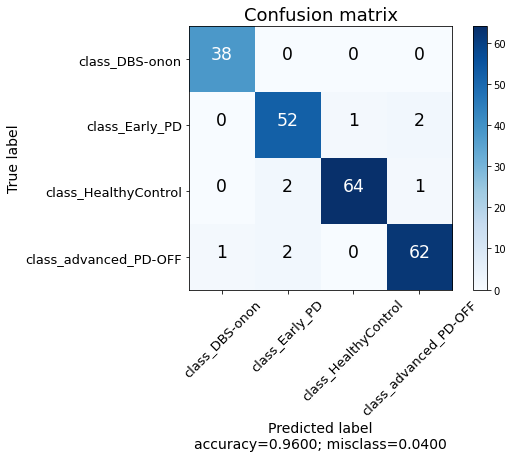


CrossValidation: Epoch 2 of 10
New folder has been created!
Subfolders have been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
Found 2015 files belonging to 4 classes.
Found 225 files belonging to 4 classes.
Epoch 1/100
63/63 [==============================] - 7s 80ms/step - loss: 1.4128 - accuracy: 0.5146 - val_loss: 1.8994 - val_accuracy: 0.1733 - lr: 0.0010
Epoch 2/100
63/63 [==============================] - 5s 75ms/step - loss: 0.6554 - accuracy: 0.7434 - val_loss: 3.0648 - val_accuracy: 0.1733 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - 5s 75ms/step - loss: 0.3151 - accuracy: 0.8824 - val_loss: 3.8043 - val_accuracy: 0.1733 - lr: 0.0010
Epoch 4/100
63/63 [==============================] - 5s 75ms/step - loss: 0.1517 - accuracy: 0.9509 - val_loss: 11.2124 - val_accur

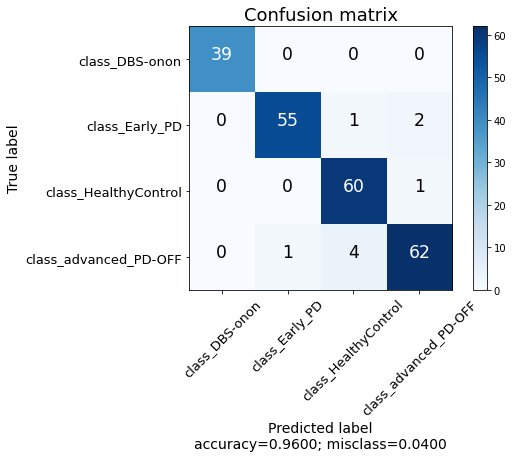


CrossValidation: Epoch 3 of 10
New folder has been created!
Subfolders have been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
Found 2015 files belonging to 4 classes.
Found 225 files belonging to 4 classes.
Epoch 1/100
63/63 [==============================] - 7s 80ms/step - loss: 1.3585 - accuracy: 0.5032 - val_loss: 1.7408 - val_accuracy: 0.2978 - lr: 0.0010
Epoch 2/100
63/63 [==============================] - 5s 75ms/step - loss: 0.7199 - accuracy: 0.7280 - val_loss: 2.2416 - val_accuracy: 0.2756 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - 5s 75ms/step - loss: 0.3967 - accuracy: 0.8432 - val_loss: 3.0179 - val_accuracy: 0.2978 - lr: 0.0010
Epoch 4/100
63/63 [==============================] - 5s 75ms/step - loss: 0.2317 - accuracy: 0.9266 - val_loss: 5.7389 - val_accura

                       precision    recall  f1-score   support

       class_DBS-onon       0.97      1.00      0.99        38
       class_Early_PD       0.95      0.91      0.93        58
 class_HealthyControl       0.94      0.95      0.95        64
class_advanced_PD-OFF       0.95      0.95      0.95        65

             accuracy                           0.95       225
            macro avg       0.95      0.96      0.95       225
         weighted avg       0.95      0.95      0.95       225



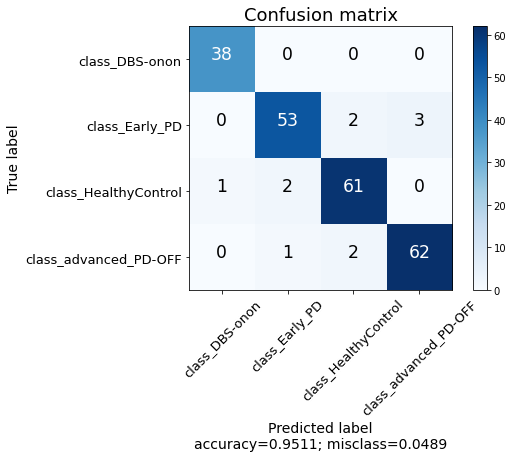


CrossValidation: Epoch 4 of 10
New folder has been created!
Subfolders have been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
Found 2015 files belonging to 4 classes.
Found 225 files belonging to 4 classes.
Epoch 1/100
63/63 [==============================] - 7s 80ms/step - loss: 1.3430 - accuracy: 0.5186 - val_loss: 1.8290 - val_accuracy: 0.2311 - lr: 0.0010
Epoch 2/100
63/63 [==============================] - 5s 76ms/step - loss: 0.6268 - accuracy: 0.7648 - val_loss: 1.3892 - val_accuracy: 0.2889 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - 5s 75ms/step - loss: 0.3712 - accuracy: 0.8576 - val_loss: 2.6632 - val_accuracy: 0.2178 - lr: 0.0010
Epoch 4/100
63/63 [==============================] - 5s 77ms/step - loss: 0.2040 - accuracy: 0.9429 - val_loss: 3.9134 - val_accura

63/63 [==============================] - 9s 127ms/step - loss: 0.0093 - accuracy: 0.9990 - val_loss: 0.0923 - val_accuracy: 0.9778 - lr: 1.0000e-04
Epoch 27/100
63/63 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 0.9995

63/63 [==============================] - 9s 137ms/step - loss: 0.0066 - accuracy: 0.9995 - val_loss: 0.0843 - val_accuracy: 0.9778 - lr: 1.0000e-04
Epoch 28/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0089 - accuracy: 0.9990 - val_loss: 0.0851 - val_accuracy: 0.9822 - lr: 1.0000e-04
Epoch 29/100
62/63 [============================>.] - ETA: 0s - loss: 0.0053 - accuracy: 0.9990

63/63 [==============================] - 9s 128ms/step - loss: 0.0053 - accuracy: 0.9990 - val_loss: 0.0802 - val_accuracy: 0.9778 - lr: 1.0000e-04
Epoch 30/100
63/63 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 1.0000

63/63 [==============================] - 9s 132ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0785 - val_accuracy: 0.9778 - lr: 1.0000e-04
Epoch 31/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0813 - val_accuracy: 0.9733 - lr: 1.0000e-04
Epoch 32/100
63/63 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000

63/63 [==============================] - 9s 128ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0775 - val_accuracy: 0.9778 - lr: 1.0000e-04
Epoch 33/100
63/63 [==============================] - 6s 77ms/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.0780 - val_accuracy: 0.9778 - lr: 1.0000e-04
Epoch 34/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0047 - accuracy: 0.9995 - val_loss: 0.0791 - val_accuracy: 0.9778 - lr: 1.0000e-04
Epoch 35/100
63/63 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

63/63 [==============================] - 9s 133ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0756 - val_accuracy: 0.9778 - lr: 1.0000e-04
Epoch 36/100
63/63 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

63/63 [==============================] - 9s 128ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0740 - val_accuracy: 0.9778 - lr: 1.0000e-04
Epoch 37/100
63/63 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

63/63 [==============================] - 9s 133ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0702 - val_accuracy: 0.9822 - lr: 1.0000e-04
Epoch 38/100
63/63 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

63/63 [==============================] - 9s 132ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0672 - val_accuracy: 0.9822 - lr: 1.0000e-04
Epoch 39/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0694 - val_accuracy: 0.9778 - lr: 1.0000e-04
Epoch 40/100
63/63 [==============================] - 5s 76ms/step - loss: 0.0031 - accuracy: 0.9995 - val_loss: 0.0694 - val_accuracy: 0.9778 - lr: 1.0000e-04
Epoch 41/100
63/63 [==============================] - 6s 80ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0696 - val_accuracy: 0.9778 - lr: 1.0000e-04
Epoch 42/100
63/63 [==============================] - 5s 76ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0678 - val_accuracy: 0.9778 - lr: 1.0000e-04
Epoch 43/100
63/63 [==============================] - 6s 79ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0734 - val_accuracy: 0.9689 - lr: 1.0000e-04
Epoch 44/100
63/63 [==============================] 

                       precision    recall  f1-score   support

       class_DBS-onon       1.00      0.97      0.99        40
       class_Early_PD       0.96      0.98      0.97        55
 class_HealthyControl       0.98      0.98      0.98        65
class_advanced_PD-OFF       0.98      0.98      0.98        65

             accuracy                           0.98       225
            macro avg       0.98      0.98      0.98       225
         weighted avg       0.98      0.98      0.98       225



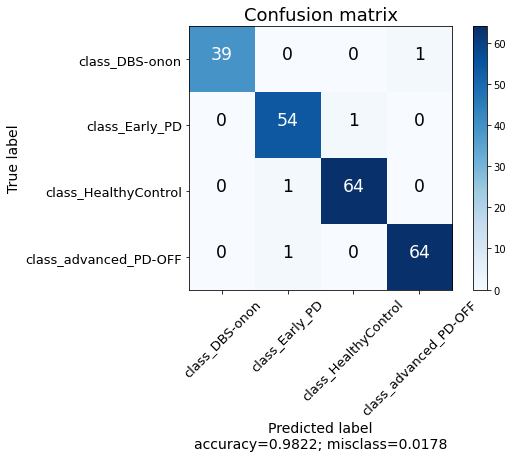


CrossValidation: Epoch 5 of 10
New folder has been created!
Subfolders have been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
Found 2016 files belonging to 4 classes.
Found 224 files belonging to 4 classes.
Epoch 1/100
63/63 [==============================] - 7s 80ms/step - loss: 1.2832 - accuracy: 0.5312 - val_loss: 2.3423 - val_accuracy: 0.2902 - lr: 0.0010
Epoch 2/100
63/63 [==============================] - 5s 76ms/step - loss: 0.7338 - accuracy: 0.7252 - val_loss: 1.5395 - val_accuracy: 0.3839 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - 5s 75ms/step - loss: 0.6622 - accuracy: 0.7693 - val_loss: 13.0859 - val_accuracy: 0.2902 - lr: 0.0010
Epoch 4/100
63/63 [==============================] - 5s 76ms/step - loss: 0.3780 - accuracy: 0.8547 - val_loss: 4.2927 - val_accur

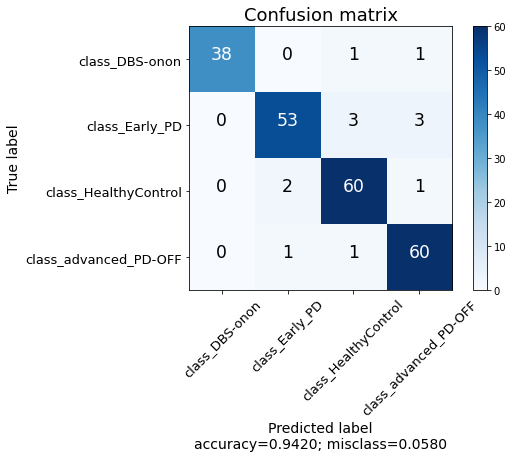


CrossValidation: Epoch 6 of 10
New folder has been created!
Subfolders have been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
Found 2016 files belonging to 4 classes.
Found 224 files belonging to 4 classes.
Epoch 1/100
63/63 [==============================] - 7s 80ms/step - loss: 1.4181 - accuracy: 0.5020 - val_loss: 1.4911 - val_accuracy: 0.3438 - lr: 0.0010
Epoch 2/100
63/63 [==============================] - 5s 75ms/step - loss: 1.0082 - accuracy: 0.6349 - val_loss: 3.1685 - val_accuracy: 0.2902 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - 5s 75ms/step - loss: 0.7294 - accuracy: 0.7207 - val_loss: 1.6267 - val_accuracy: 0.3661 - lr: 0.0010
Epoch 4/100
63/63 [==============================] - 6s 80ms/step - loss: 0.4434 - accuracy: 0.8487 - val_loss: 3.0857 - val_accura

63/63 [==============================] - 9s 135ms/step - loss: 0.0205 - accuracy: 0.9965 - val_loss: 0.0649 - val_accuracy: 0.9821 - lr: 1.0000e-04
Epoch 33/100
63/63 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9970

63/63 [==============================] - 9s 127ms/step - loss: 0.0188 - accuracy: 0.9970 - val_loss: 0.0635 - val_accuracy: 0.9866 - lr: 1.0000e-04
Epoch 34/100
63/63 [==============================] - 6s 81ms/step - loss: 0.0176 - accuracy: 0.9980 - val_loss: 0.0642 - val_accuracy: 0.9866 - lr: 1.0000e-04
Epoch 35/100
62/63 [============================>.] - ETA: 0s - loss: 0.0130 - accuracy: 0.9995

63/63 [==============================] - 9s 135ms/step - loss: 0.0132 - accuracy: 0.9995 - val_loss: 0.0615 - val_accuracy: 0.9866 - lr: 1.0000e-04
Epoch 36/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0191 - accuracy: 0.9960 - val_loss: 0.0648 - val_accuracy: 0.9821 - lr: 1.0000e-04
Epoch 37/100
63/63 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.9980

63/63 [==============================] - 9s 129ms/step - loss: 0.0180 - accuracy: 0.9980 - val_loss: 0.0528 - val_accuracy: 0.9911 - lr: 1.0000e-04
Epoch 38/100
63/63 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9975

63/63 [==============================] - 9s 134ms/step - loss: 0.0142 - accuracy: 0.9975 - val_loss: 0.0526 - val_accuracy: 0.9866 - lr: 1.0000e-04
Epoch 39/100
63/63 [==============================] - 5s 76ms/step - loss: 0.0109 - accuracy: 0.9990 - val_loss: 0.0559 - val_accuracy: 0.9911 - lr: 1.0000e-04
Epoch 40/100
63/63 [==============================] - 6s 82ms/step - loss: 0.0137 - accuracy: 0.9975 - val_loss: 0.0740 - val_accuracy: 0.9821 - lr: 1.0000e-04
Epoch 41/100
63/63 [==============================] - 5s 76ms/step - loss: 0.0128 - accuracy: 0.9965 - val_loss: 0.0595 - val_accuracy: 0.9777 - lr: 1.0000e-04
Epoch 42/100
63/63 [==============================] - 5s 76ms/step - loss: 0.0110 - accuracy: 0.9985 - val_loss: 0.0585 - val_accuracy: 0.9821 - lr: 1.0000e-04
Epoch 43/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0105 - accuracy: 0.9985 - val_loss: 0.0634 - val_accuracy: 0.9777 - lr: 1.0000e-04
Epoch 44/100
63/63 [==============================] 

63/63 [==============================] - 9s 129ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0523 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 56/100
63/63 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.9990

63/63 [==============================] - 9s 134ms/step - loss: 0.0056 - accuracy: 0.9990 - val_loss: 0.0522 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 57/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0527 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 58/100
63/63 [==============================] - 5s 74ms/step - loss: 0.0073 - accuracy: 0.9995 - val_loss: 0.0523 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 59/100
63/63 [==============================] - 5s 76ms/step - loss: 0.0074 - accuracy: 0.9995 - val_loss: 0.0528 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 60/100
63/63 [==============================] - 6s 81ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0532 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 61/100
63/63 [==============================] - 6s 80ms/step - loss: 0.0050 - accuracy: 0.9995 - val_loss: 0.0538 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 62/100
63/63 [==============================] 

63/63 [==============================] - 9s 128ms/step - loss: 0.0064 - accuracy: 0.9995 - val_loss: 0.0512 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 65/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0084 - accuracy: 0.9990 - val_loss: 0.0532 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 66/100
63/63 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.9995

63/63 [==============================] - 9s 129ms/step - loss: 0.0071 - accuracy: 0.9995 - val_loss: 0.0507 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 67/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.0515 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 68/100
63/63 [==============================] - 5s 76ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0531 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 69/100
63/63 [==============================] - 6s 80ms/step - loss: 0.0052 - accuracy: 0.9990 - val_loss: 0.0536 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 70/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0530 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 71/100
63/63 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 0.9980

63/63 [==============================] - 9s 133ms/step - loss: 0.0075 - accuracy: 0.9980 - val_loss: 0.0499 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 72/100
63/63 [==============================] - 5s 76ms/step - loss: 0.0059 - accuracy: 0.9995 - val_loss: 0.0518 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 73/100
63/63 [==============================] - 5s 76ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0516 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 74/100
63/63 [==============================] - 5s 76ms/step - loss: 0.0064 - accuracy: 0.9995 - val_loss: 0.0508 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 75/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0082 - accuracy: 0.9985 - val_loss: 0.0499 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 76/100
63/63 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9995

63/63 [==============================] - 9s 133ms/step - loss: 0.0062 - accuracy: 0.9995 - val_loss: 0.0488 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 77/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0493 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 78/100
63/63 [==============================] - 5s 76ms/step - loss: 0.0063 - accuracy: 0.9995 - val_loss: 0.0519 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 79/100
63/63 [==============================] - 5s 76ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0519 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 80/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0047 - accuracy: 0.9995 - val_loss: 0.0512 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 81/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0519 - val_accuracy: 0.9866 - lr: 1.0000e-05
Epoch 82/100
63/63 [==============================] 

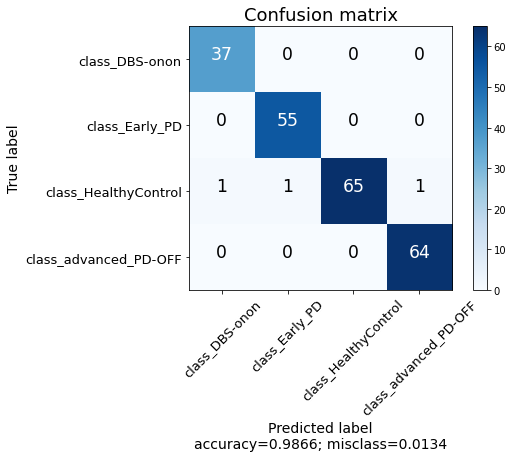


CrossValidation: Epoch 7 of 10
New folder has been created!
Subfolders have been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
Found 2016 files belonging to 4 classes.
Found 224 files belonging to 4 classes.
Epoch 1/100
63/63 [==============================] - 7s 80ms/step - loss: 1.5720 - accuracy: 0.4722 - val_loss: 2.0116 - val_accuracy: 0.1696 - lr: 0.0010
Epoch 2/100
63/63 [==============================] - 5s 76ms/step - loss: 0.7567 - accuracy: 0.7078 - val_loss: 2.0823 - val_accuracy: 0.2991 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - 5s 75ms/step - loss: 0.4055 - accuracy: 0.8566 - val_loss: 2.9330 - val_accuracy: 0.2902 - lr: 0.0010
Epoch 4/100
63/63 [==============================] - 5s 76ms/step - loss: 0.2763 - accuracy: 0.9028 - val_loss: 2.6198 - val_accura

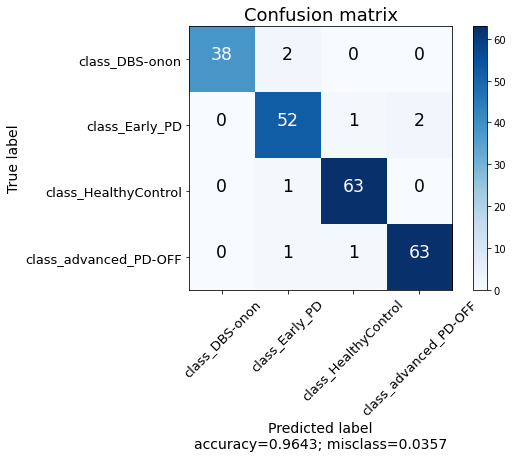


CrossValidation: Epoch 8 of 10
New folder has been created!
Subfolders have been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
Found 2016 files belonging to 4 classes.
Found 224 files belonging to 4 classes.
Epoch 1/100
63/63 [==============================] - 7s 80ms/step - loss: 1.4351 - accuracy: 0.5124 - val_loss: 3.3153 - val_accuracy: 0.2902 - lr: 0.0010
Epoch 2/100
63/63 [==============================] - 5s 76ms/step - loss: 0.7918 - accuracy: 0.6969 - val_loss: 3.9000 - val_accuracy: 0.2902 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - 5s 76ms/step - loss: 0.4360 - accuracy: 0.8393 - val_loss: 5.8137 - val_accuracy: 0.1696 - lr: 0.0010
Epoch 4/100
63/63 [==============================] - 5s 76ms/step - loss: 0.2964 - accuracy: 0.8948 - val_loss: 6.5528 - val_accura

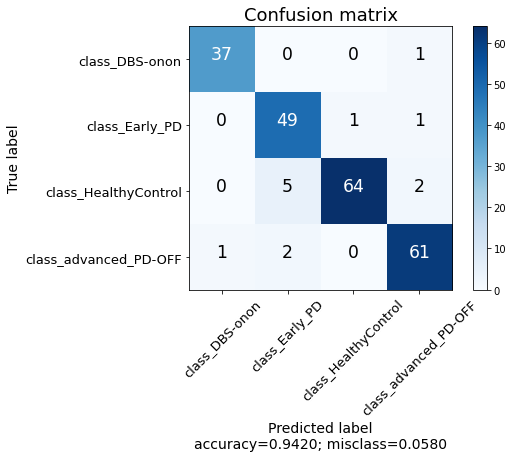


CrossValidation: Epoch 9 of 10
New folder has been created!
Subfolders have been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
Found 2018 files belonging to 4 classes.
Found 222 files belonging to 4 classes.
Epoch 1/100
64/64 [==============================] - 7s 83ms/step - loss: 1.3630 - accuracy: 0.5050 - val_loss: 1.7482 - val_accuracy: 0.2883 - lr: 0.0010
Epoch 2/100
64/64 [==============================] - 5s 74ms/step - loss: 1.0050 - accuracy: 0.6358 - val_loss: 5.7777 - val_accuracy: 0.2523 - lr: 0.0010
Epoch 3/100
64/64 [==============================] - 5s 74ms/step - loss: 0.6119 - accuracy: 0.7696 - val_loss: 2.8161 - val_accuracy: 0.2523 - lr: 0.0010
Epoch 4/100
64/64 [==============================] - 5s 75ms/step - loss: 0.5459 - accuracy: 0.7914 - val_loss: 6.3368 - val_accura

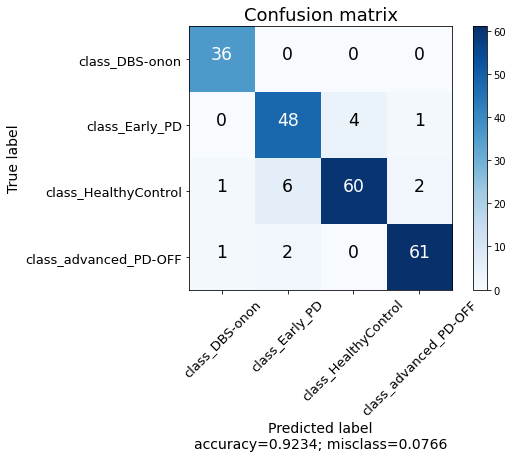


CrossValidation: Epoch 10 of 10
New folder has been created!
Subfolders have been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
New folder has been created!
Found 2018 files belonging to 4 classes.
Found 222 files belonging to 4 classes.
Epoch 1/100
64/64 [==============================] - 7s 79ms/step - loss: 1.3923 - accuracy: 0.4970 - val_loss: 1.5846 - val_accuracy: 0.2973 - lr: 0.0010
Epoch 2/100
64/64 [==============================] - 5s 75ms/step - loss: 0.7689 - accuracy: 0.7131 - val_loss: 2.0253 - val_accuracy: 0.3063 - lr: 0.0010
Epoch 3/100
64/64 [==============================] - 5s 74ms/step - loss: 0.4252 - accuracy: 0.8479 - val_loss: 2.0922 - val_accuracy: 0.3063 - lr: 0.0010
Epoch 4/100
64/64 [==============================] - 5s 75ms/step - loss: 0.2219 - accuracy: 0.9197 - val_loss: 1.8635 - val_accur

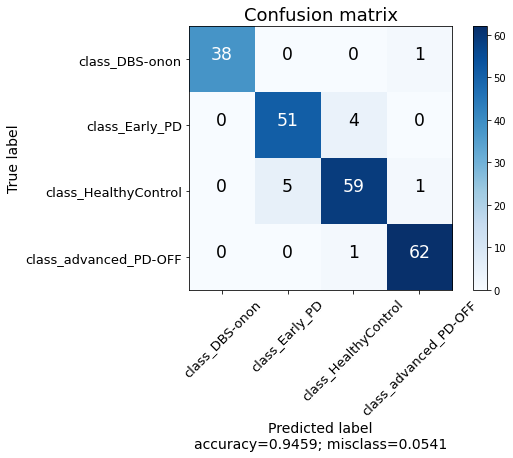

In [22]:
historyList = []
info = pd.DataFrame([])
stats = pd.DataFrame([])
# Train the model with k-fold crossvalidation
for fold in range(0,k):
  if fold > 0:
    # clear the previous model
    del model  
  kfold_time = time.time()
  print('\nCrossValidation: Epoch', fold+1,'of',k)
  # Make new directory for training and test set 
  ImageList, ImageLabel, ImageListTest, ImageLabelTest, newfolderpath, \
   testsubfolder, trainsubfolder = \
   makeNewDirectory(fold,TrainSet,TestSet,local_path,fileName)
  CopyFile(trainsubfolder, ImageList)
  CopyFile(testsubfolder, ImageListTest)
  # obtain dataset for the K-th folder
  train_batches, test_batches, classNames, N_CLASSES, \
  image_paths_train, image_paths_valid, train_dataset, \
  valid_dataset, LabelNames = ReadSetForKfold(trainsubfolder,testsubfolder,\
                                              BATCH_SIZE,MODE,IMAGE_HEIGHT, IMAGE_WIDTH)
  # make model
  model = make_model(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS, N_CLASSES, num_cnn_layers)
  # Compile model
  model.compile(
    loss = LOSS,
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    metrics=['accuracy'])
  # Train model and capture the history
  history = model.fit(train_dataset, 
                    epochs=EPOCHS, 
                    validation_data = valid_dataset,
                    callbacks = [earlyStopping, mcp_save, reduce_lr_loss]
                    )
  historyList.append(history)
  # Compute the final loss and accuracy
  final_acc = historyList[fold].history['val_accuracy'][-1]
  final_loss = historyList[fold].history['val_loss'][-1]
  print("\nFinal loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))
  runtimeK = time.time() - kfold_time
  print('\nRuntime:')
  print("--- %s seconds ---" % (runtimeK))
  print("--- %s minutes ---" % ((runtimeK)/60))
  # Save all the data to a dictionary
  # dictionary of lists  
  InfoDict = {'IMAGE_HEIGHT':[IMAGE_HEIGHT], 'IMAGE_WIDTH':[IMAGE_WIDTH],
              'BATCH_SIZE': [BATCH_SIZE], 'N_CHANNELS': [N_CHANNELS], 'N_CLASSES': [N_CLASSES],
              'EPOCHS':[EPOCHS], 'VAL_SPLIT': [VAL_SPLIT], 'MODE': MODE, 'K-Fold' : fold,
              'FINAL VALIDATION LOSS': [final_loss], 'FINAL VALIDATION ACC': [final_acc],
              'RUNTIME (s)': [runtimeK], 'RUNTIME (min)': [runtimeK/60]
              }
  info = pd.concat([info, pd.DataFrame(InfoDict)])
  # Classification Report
  pred_labels, true_labels = Evaluate_Batches(valid_dataset)
  print(classification_report(true_labels, pred_labels, target_names = LabelNames))
  # Confusion Matrix
  confusion_mtx = confusion_matrix(true_labels, pred_labels)
  plot_confusion_matrix(confusion_mtx,
                          LabelNames,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)
  # Statistics
  Stat_df = ComputeStatistics(LabelNames,confusion_mtx,true_labels, pred_labels,runtimeK,fold)
  stats = pd.concat([stats, Stat_df])

Save data

In [23]:
# saving the dataframe 
outputName = 'Model_Info_and_Performance.xlsx'
OutputFileName = os.path.join(outputPath,outputName)
# writing to Excel
stats.to_excel(OutputFileName)
outputRecap = 'Model_Performance_Recap.xlsx'
OutputFileNameRecap = os.path.join(outputPath,outputRecap)
statRecap = stats.describe()
statRecap.to_excel(OutputFileNameRecap)

In [24]:
stats.describe()

,precision,recall,f1-score,support
count,70.000000,70.000000,70.000000,70.000000
mean,0.957371,0.957764,0.957284,96.136536
std,0.027970,0.027281,0.024293,84.004554
min,0.857143,0.869565,0.880734,0.923423
25%,0.942946,0.945577,0.942039,40.000000
50%,0.960000,0.955553,0.959999,64.000000
75%,0.982143,0.981742,0.976653,222.000000
max,1.000000,1.000000,1.000000,225.000000


Plot Label of dataset

<function matplotlib.pyplot.show(*args, **kw)>

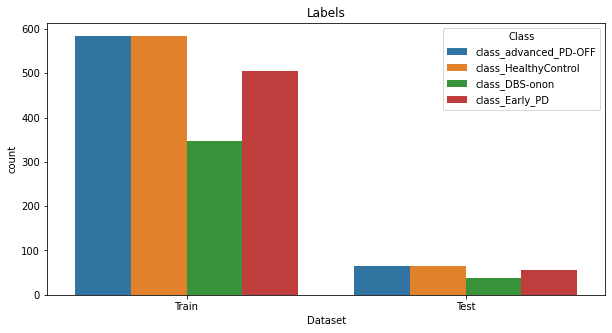

In [25]:
plt.figure(figsize=(10, 5))

ImageLabeldf = pd.DataFrame(ImageLabel) 
ImageLabeldf['Dataset'] = 'Train'

ImageLabelTestdf = pd.DataFrame(ImageLabelTest) 
ImageLabelTestdf['Dataset'] = 'Test'

frames = [ImageLabeldf, ImageLabelTestdf]
resultDFSet = pd.concat(frames)

sns.countplot(data=resultDFSet, x="Dataset", hue="Class")
plt.title('Labels')
plt.show

Plot Model Summary

In [26]:
Summary = os.path.join(outputPath,'modelsummary.txt')
modelInfo = model.summary()

stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)

with open(Summary, 'w') as f:
  # Pass the file handle in as a lambda function to make it callable
  f.write(short_model_summary)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 batch_normalization_81 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 batch_normalization_82 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 64)      18496     
                                                      

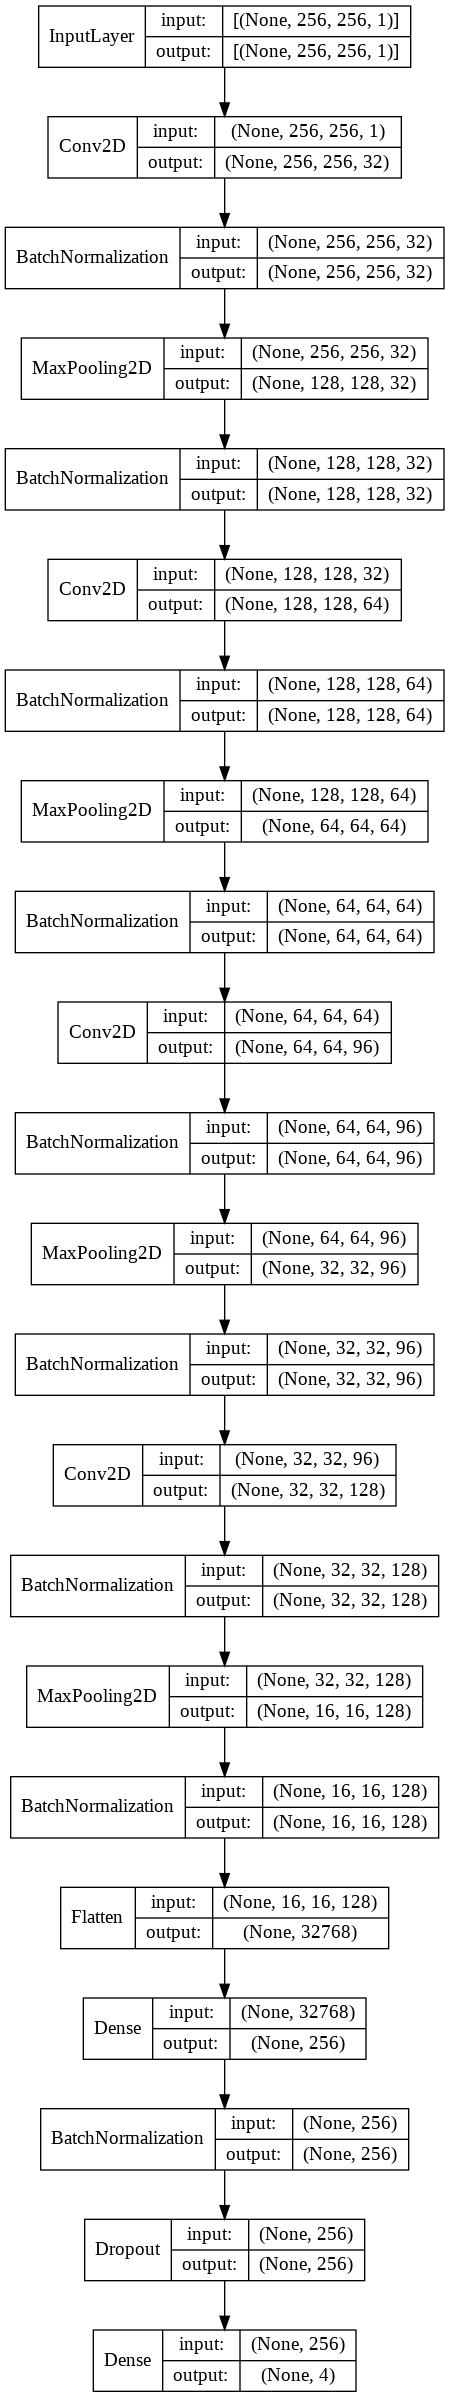

In [27]:
pngOutput = os.path.join(outputPath,'model_plot.png')
plot_model(model, to_file=pngOutput, show_shapes=True, show_layer_names=False)

Plots to see how the models are performing

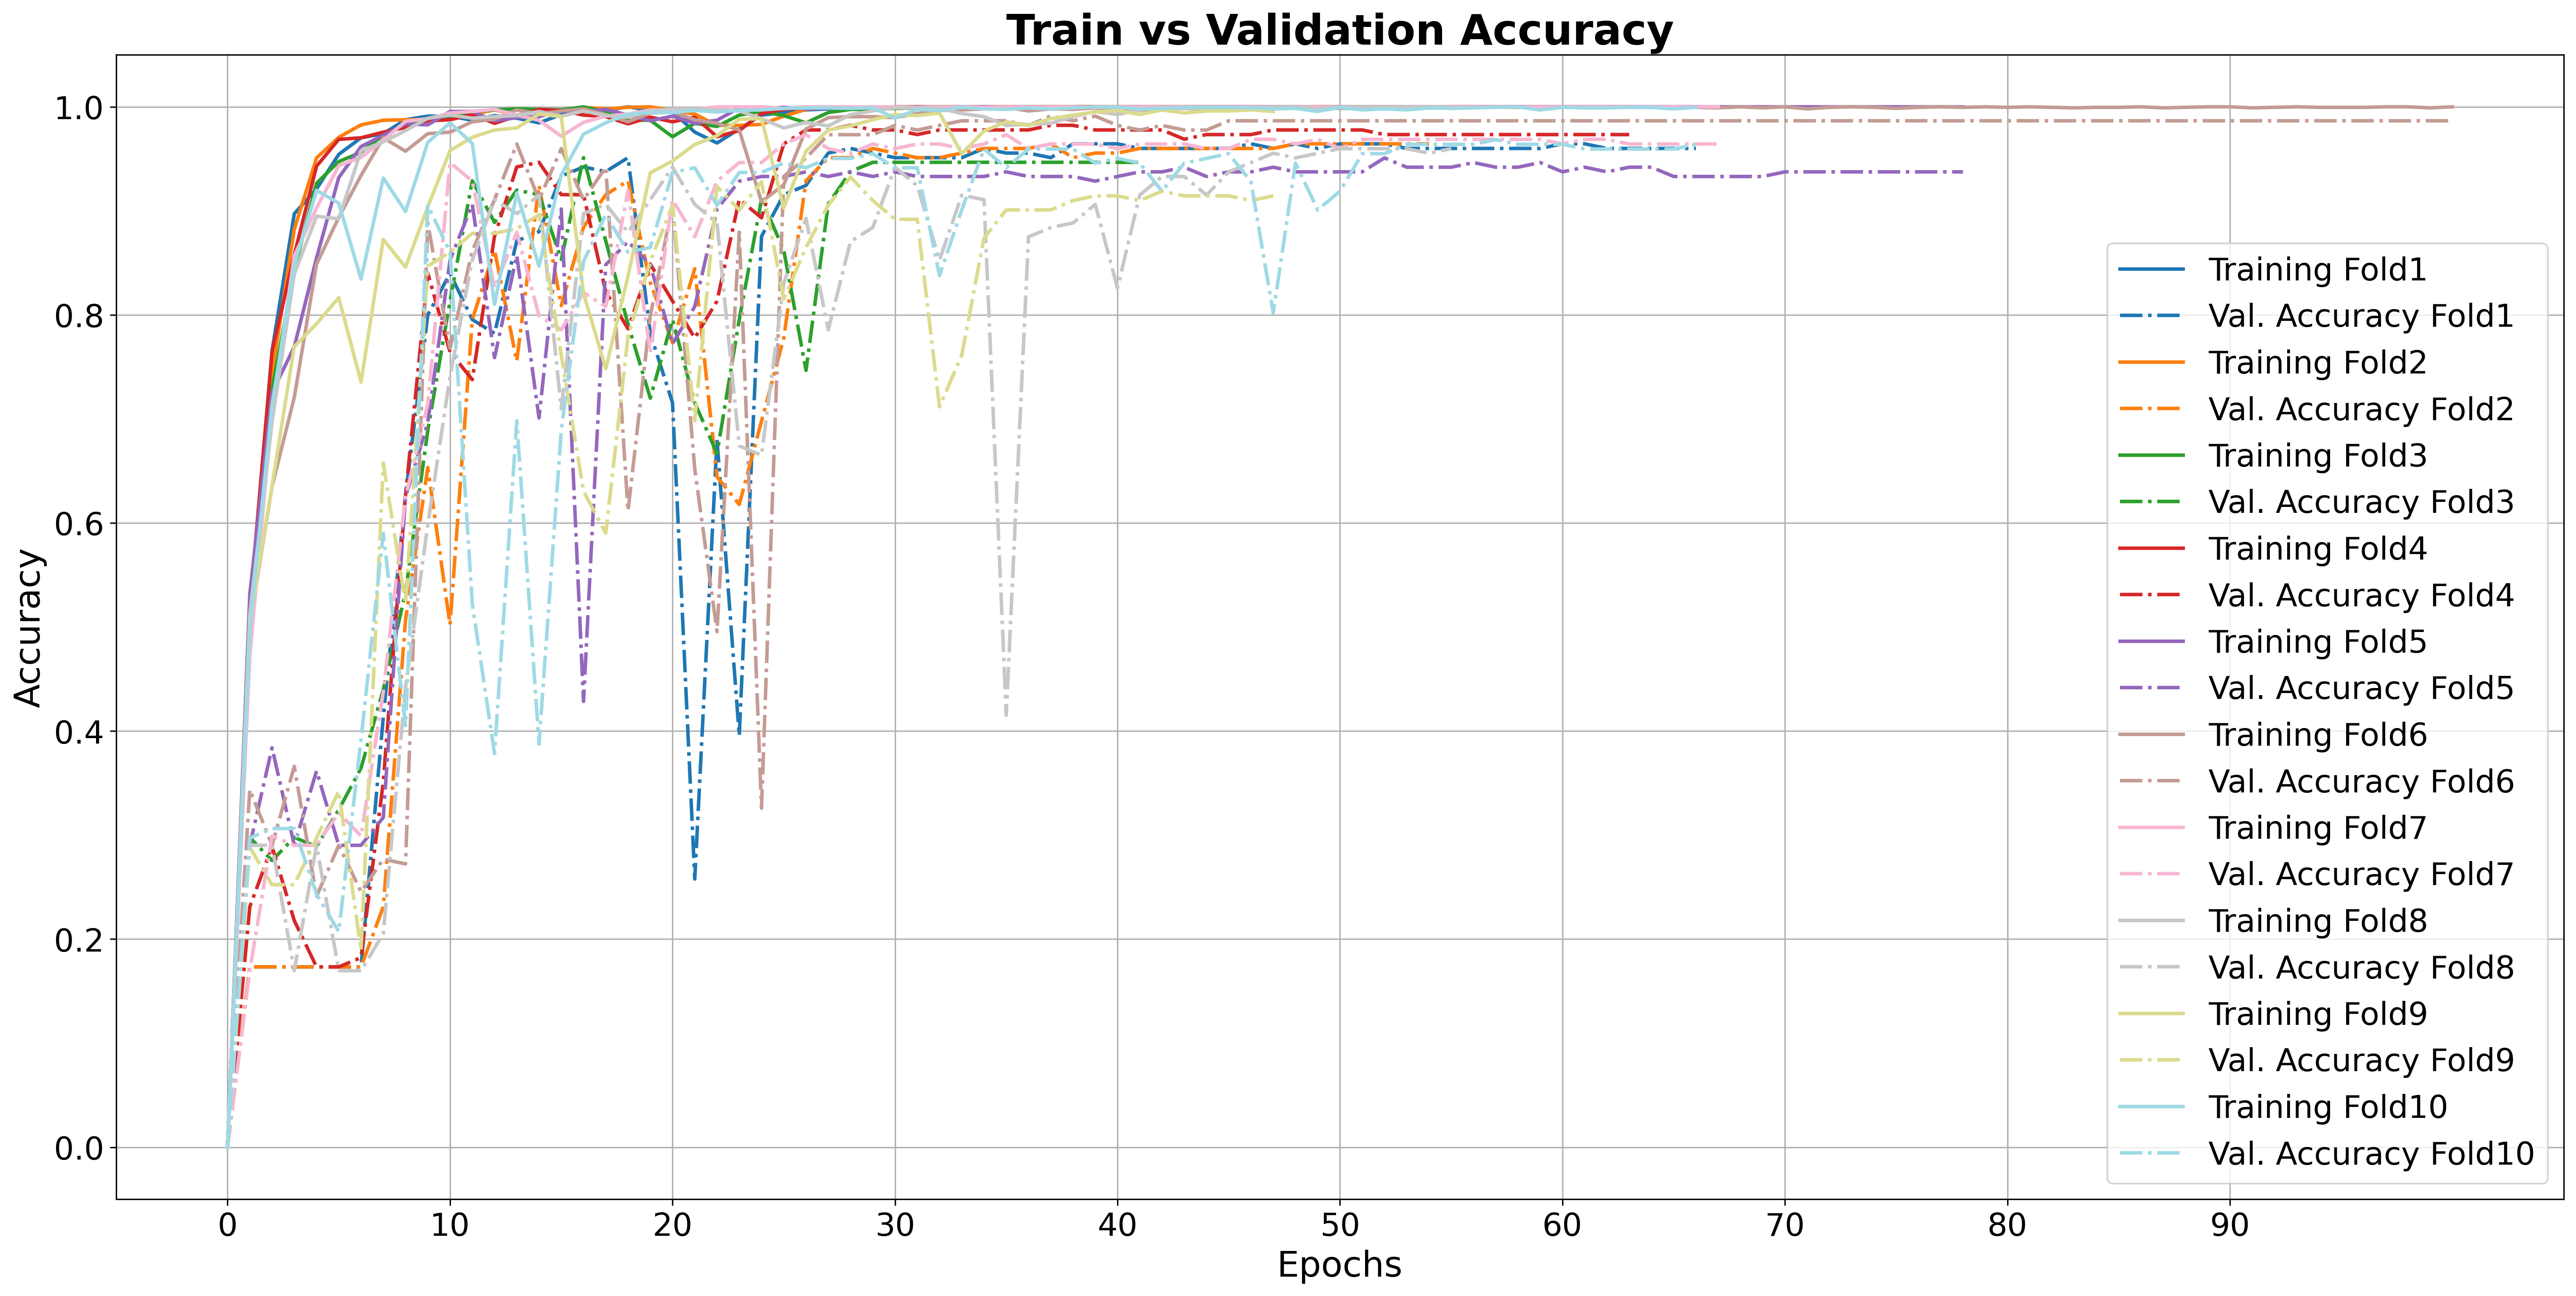

In [28]:
colormap= plt.get_cmap('tab20')
colors = iter(colormap(np.linspace(0,1,10)))
fig = plt.figure(figsize=(25, 12), dpi=300)
font = {'size' : 18}
plt.rc('font', **font)

for fold in range(0,k):
  color=next(colors)  
  kTrainAcc = [0] + historyList[fold].history['accuracy']
  kValAcc = [0] + historyList[fold].history['val_accuracy']
  epochs = list(range(0, len(kTrainAcc)))
  plt.plot(epochs, kTrainAcc, label='Training Fold'+str(fold+1),color=color,linewidth=2)
  plt.plot(epochs, kValAcc,label='Val. Accuracy Fold'+str(fold+1), \
           linestyle = "dashdot",color=color,linewidth=2)
plt.legend()
plt.grid()
plt.title("Train vs Validation Accuracy", fontsize=24,fontweight='bold')
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.xticks(range(0,EPOCHS,10))
plt.show()
outputName = os.path.join(outputPath,'Accuracy')
fig.savefig(outputName, dpi=300, format='png',pad_inches=0)

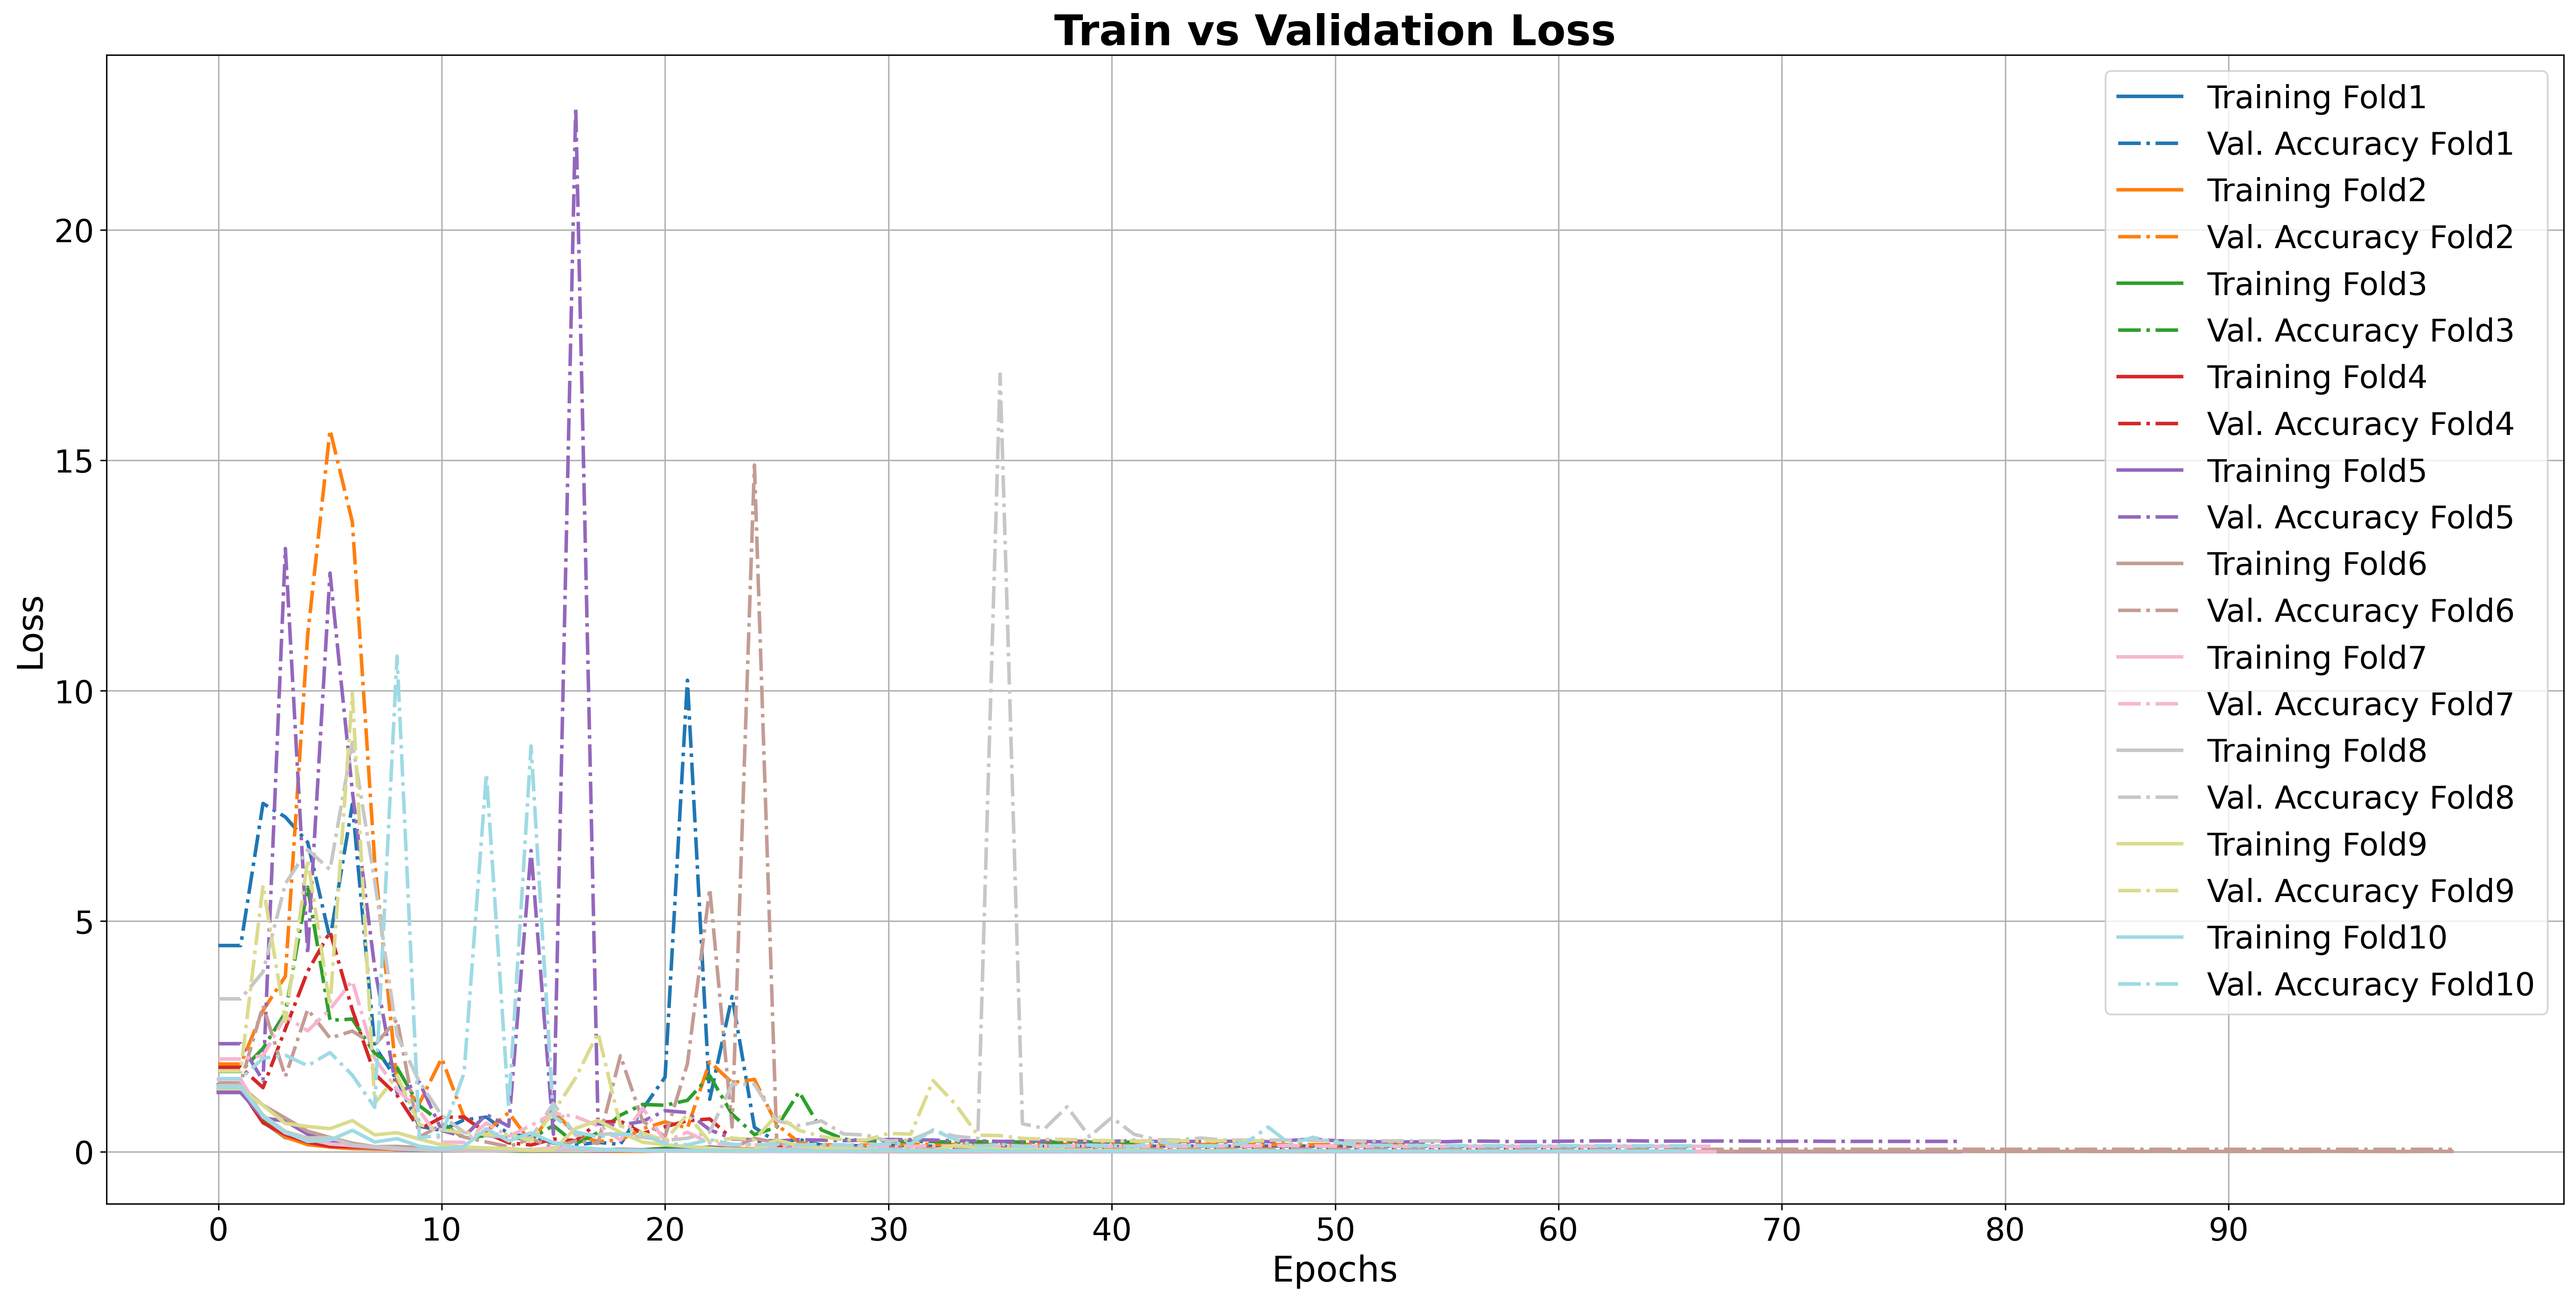

In [29]:
colormap= plt.get_cmap('tab20')
colors = iter(colormap(np.linspace(0,1,10)))
fig = plt.figure(figsize=(25, 12),dpi=300)
font = {'size'   : 18}
plt.rc('font', **font)

for fold in range(0,k):
  color=next(colors)  
  kTrainLoss = [historyList[fold].history['loss'][0]] + historyList[fold].history['loss']
  kValLoss = [historyList[fold].history['val_loss'][0]] + historyList[fold].history['val_loss']
  epochs = list(range(0, len(kTrainLoss)))
  plt.plot(epochs, kTrainLoss, label='Training Fold'+str(fold+1),color=color,linewidth=2)
  plt.plot(epochs, kValLoss,label='Val. Accuracy Fold'+str(fold+1), \
           linestyle = "dashdot",color=color,linewidth=2)
plt.legend()
plt.grid()
plt.title("Train vs Validation Loss", fontsize=24,fontweight='bold')
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.xticks(range(0,EPOCHS,10))
plt.show()
outputName = os.path.join(outputPath,'Loss')
fig.savefig(outputName, dpi=300, format='png',pad_inches=0)